In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time
from scipy.stats import norm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helper import df_to_latex, fig_path, set_figsize, tab_path

# Import code from src
sys.path.insert(0, '../src/')
import vmc 

In [2]:
pd.set_option('display.max_columns', 50)
#pd.options.display.float_format= '{e:.5f}'.format 
# Set plot style
sns.set(context="paper", style='darkgrid', rc={"axes.facecolor": "0.96"})

fontsize = "large"

params = {"font.family": "serif",
          "font.sans-serif": ["Computer Modern"],
          "axes.labelsize": fontsize,
          #"font.size": fontsize,
          "legend.fontsize": fontsize,
          "xtick.labelsize": fontsize,
          "ytick.labelsize": fontsize,
          "legend.handlelength": 2
         }
          
    
plt.rcParams.update(params)
plt.rc('text', usetex=True)

In [3]:
def exact_energy(N, dim, omega):
    return (omega * dim * N) / 2


def safe_initial_positions_no_interactions(wavefunction, alpha, N, dim, seed=None):
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))

    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14:
        positions *= 0.5
        wf2 = wavefunction.pdf(positions, alpha)

    return positions


def safe_initial_positions_w_interactions(wavefunction, alpha, N, dim, seed=None): 
    rng = np.random.default_rng(seed=seed)
    positions = rng.random(size=(N, dim))
    
    # safe initialization
    wf2 = wavefunction.pdf(positions, alpha)
    while np.sum(wf2) <= 1e-14: 
        positions *= 2.0
        wf2 = wavefunction.pdf(positions, alpha)
        
    return positions


def interact_initial_positions(wf, alpha, N, dim, a=0.00433):

    rng = np.random.default_rng()

    def corr_factor(r1, r2):
        rij = np.linalg.norm(r1 - r2)
        if rij <= a:
            return 0.
        else:
            return 1 - (a / rij)

    scale = 2.
    r = np.random.randn(N, dim) * scale
    #r = rng.random(size=(N, dim))

    rerun = True
    while rerun:
        rerun = False
        for i in range(N):
            for j in range(i + 1, N):
                corr = corr_factor(r[i, :], r[j, :])
                if corr == 0.:
                    print("corr=0 encountered")
                    rerun = True
                    r[i, :] = np.random.randn() * scale
                    r[j, :] = np.random.randn() * scale
        scale *= 1.5

    return r, scale


def get_mean_w_standard_error_grid_search(data, alphas): 
    data_dict = {"alpha": alphas, "energy": [], "standard_error":[],"standard_error_of_the_mean": []}
    for i, alpha in enumerate(alphas): 
        energies_alpha = data["energy"][data["alpha"]==alpha]
        standard_errors_alpha = data["standard_error"][data["alpha"]==alpha]
        mean_energy_alpha = np.mean(energies_alpha)
        standard_error = np.mean(standard_errors_alpha)
        standard_error_of_the_mean = np.std(standard_errors_alpha)/np.sqrt(len(standard_errors_alpha))
        data_dict["energy"].append(mean_energy_alpha)
        data_dict["standard_error"].append(standard_error)
        data_dict["standard_error_of_the_mean"].append(standard_error_of_the_mean)
        
    dataframe = pd.DataFrame(data=data_dict)
    return dataframe

## Verifying equality betweeen AIB and ASHOIB

In [4]:
N = [2, 5, 10, 20, 50, 100, 200, 500, 1000]
dim = 3 
omega = 1.
data_dict = {"num_particles": N, "local_energy": [], "local_energy_log_domain": []}#, "Drift force": [], "Drift force log domain": []}
drift_dict = {"Number of particles": N, "Fx": [], "Fy": [], "Fz": [], "Fx log": [], "Fy log": [], "Fz log": []}
for i in range(len(N)): 
    n = N[i]
    wflogspace = vmc.ASHOIB(n, dim, omega)
    wf = vmc.AIB(n, dim, omega)
    positions, scale = interact_initial_positions(wflogspace, 0.5, n, dim)
    
    local_energy = wf.local_energy(positions, 0.5)
    local_energy_log = wflogspace.local_energy(positions, 0.5)
    drift_force = wf.drift_force(positions, 0.5)
    drift_force_log = wflogspace.drift_force(positions, 0.5)
    
    data_dict["local_energy"].append(local_energy)
    data_dict["local_energy_log_domain"].append(local_energy_log)
    
    drift_dict["Fx"].append(drift_force[0][0])
    drift_dict["Fy"].append(drift_force[0][1])
    drift_dict["Fz"].append(drift_force[0][2])
    drift_dict["Fx log"].append(drift_force_log[0][0])
    drift_dict["Fy log"].append(drift_force_log[0][1])
    drift_dict["Fz log"].append(drift_force_log[0][2])
    
#dataframe = pd.DataFrame(data=data_dict)
#drift_dataframe = pd.DataFrame(data=drift_dict)

#df_to_latex(dataframe, "verification_table.tex")
#df_to_latex(drift_dataframe, "drift_ver_table.tex")
#dataframe["Local energy"] = dataframe["Local energy"].map('{:.5f}'.format)

NI part:  3.0
Second term:  0.0010667629663570059
Third term:  -6.892390006048442e-08
Fourth term:  6.892390006052831e-08
NI part:  7.5
Second term:  0.013507015551133345
Third term:  -4.563042243518458e-06
Fourth term:  2.571001857002175e-06
NI part:  15.0
Second term:  0.07203151095499001
Third term:  -0.011489074522901158
Fourth term:  0.011463525644083533
NI part:  30.0
Second term:  0.2078437991422042
Third term:  -0.00019802213182251973
Fourth term:  0.00013020615928939708
NI part:  75.0
Second term:  1.457945510731779
Third term:  -0.004191384442055057
Fourth term:  0.002351808122362447
NI part:  150.0
Second term:  5.617105864761447
Third term:  -0.4416711839738518
Fourth term:  0.42882608482552986
NI part:  300.0
Second term:  24.689137663740574
Third term:  -0.22909044441606427
Fourth term:  0.05548698004272079
NI part:  750.0
Second term:  151.36645874866582
Third term:  -3.742674556065473
Fourth term:  1.327725320815089
NI part:  1500.0
Second term:  617.8084741123905
Third

In [5]:
data_dict

{'num_particles': [2, 5, 10, 20, 50, 100, 200, 500, 1000],
 'local_energy': [3.001066762966357,
  7.513505023510747,
  15.072005962076172,
  30.20777598316967,
  76.45610593441208,
  155.6042607656131,
  324.5155341993672,
  898.9515095134153,
  2096.3700453227125],
 'local_energy_log_domain': [3.0010667629663565,
  7.513505023510749,
  15.072005962076169,
  30.20777598316964,
  76.45610593441211,
  155.60426076561316,
  324.5155341993674,
  898.9515095134157,
  2096.370045322713]}

In [6]:
pd.DataFrame.from_dict(data_dict)

,num_particles,local_energy,local_energy_log_domain
0,2,3.001067,3.001067
1,5,7.513505,7.513505
2,10,15.072006,15.072006
3,20,30.207776,30.207776
4,50,76.456106,76.456106
5,100,155.604261,155.604261
6,200,324.515534,324.515534
7,500,898.951510,898.951510
8,1000,2096.370045,2096.370045


In [7]:
pd.DataFrame.from_dict(drift_dict)

,Number of particles,Fx,Fy,Fz,Fx log,Fy log,Fz log
0,2,0.506207,-0.130179,0.462342,0.506672,-0.130000,0.461732
1,5,0.239654,2.251495,-2.543679,0.238948,2.246948,-2.543251
2,10,2.250925,4.009664,-6.373107,2.248794,4.010228,-6.363398
3,20,3.619061,-3.578236,3.645896,3.612394,-3.573573,3.640549
4,50,-4.122989,0.837854,5.600502,-4.112993,0.839386,5.575570
5,100,-2.274456,2.366252,3.209928,-2.239794,2.336243,3.157092
6,200,-2.624555,-13.674794,2.780589,-2.612301,-13.625380,2.773276
7,500,-4.302116,0.419551,0.610037,-3.953842,0.426823,0.695429
8,1000,-5.328209,2.902029,-1.268749,-4.734976,2.450889,-1.134551


## Grid search $\alpha$ without interactions

In [8]:
N = 50
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_10 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHONIB(N, dim, omega)

# Instantiate sampler
sampler_NI = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_NI_N10 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions = safe_initial_positions_no_interactions(wf,
                                                               alpha,
                                                               N,
                                                               dim)
                                                   
    result = sampler_NI.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=4,
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=5000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-7,
                            optimize=False
                           )
    results_NI_N10.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

Warm doneWarm done

Warm done
Warm done
Tune done
Tune done
Tune done
Warm after tune done
Warm after tune done
Warm after tune done
Tune done
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Warm after tune done
Rewarming done
Sampling energy
Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Tune done
Warm after tune done
Warm after tune done
Warm after tune done
Warm after tune done
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Warm done
Warm done
Warm done
Warm done
Tune done
Tune done
Tune done
Warm after tune done
Warm after tune done
Warm after tune done
Tune done
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Rewarming done
Sampling energy
Warm after tune done
Rewarming done
Sampling energy
Warm doneWarm done

Warm done
Warm done
Tune done
Tune done
Tune done
Tune done
Warm after tune done
Warm after tune done
Warm after tun

In [21]:
N=50
df_NI_N50 = pd.concat(results_NI_N10, ignore_index=True)
df_means_NI_N50 = get_mean_w_standard_error_grid_search(df_NI_N50, alphas)
df_means_NI_N50["energy"] = df_means_NI_N50["energy"] / N
df_means_NI_N50["standard_error"] = df_means_NI_N50["standard_error"] / N
df_means_NI_N50["standard_error"] = df_means_NI_N50["standard_error"].map('{:.0e}'.format)
df_means_NI_N50["standard_error_of_the_mean"] = df_means_NI_N50["standard_error_of_the_mean"] / N
df_means_NI_N50

,alpha,energy,standard_error,standard_error_of_the_mean
0,0.1,3.808102,0.181837,0.020875
1,0.2,2.213414,0.088569,0.010709
2,0.3,1.662024,0.032200,0.002076
3,0.4,1.518297,0.011024,0.000826
4,0.5,1.500000,0.000000,0.000000
5,0.6,1.529606,0.009170,0.001049
6,0.7,1.570589,0.018843,0.001968
7,0.8,1.653075,0.029680,0.004273
8,0.9,1.782489,0.027770,0.001044
9,1.0,1.892026,0.035097,0.003408


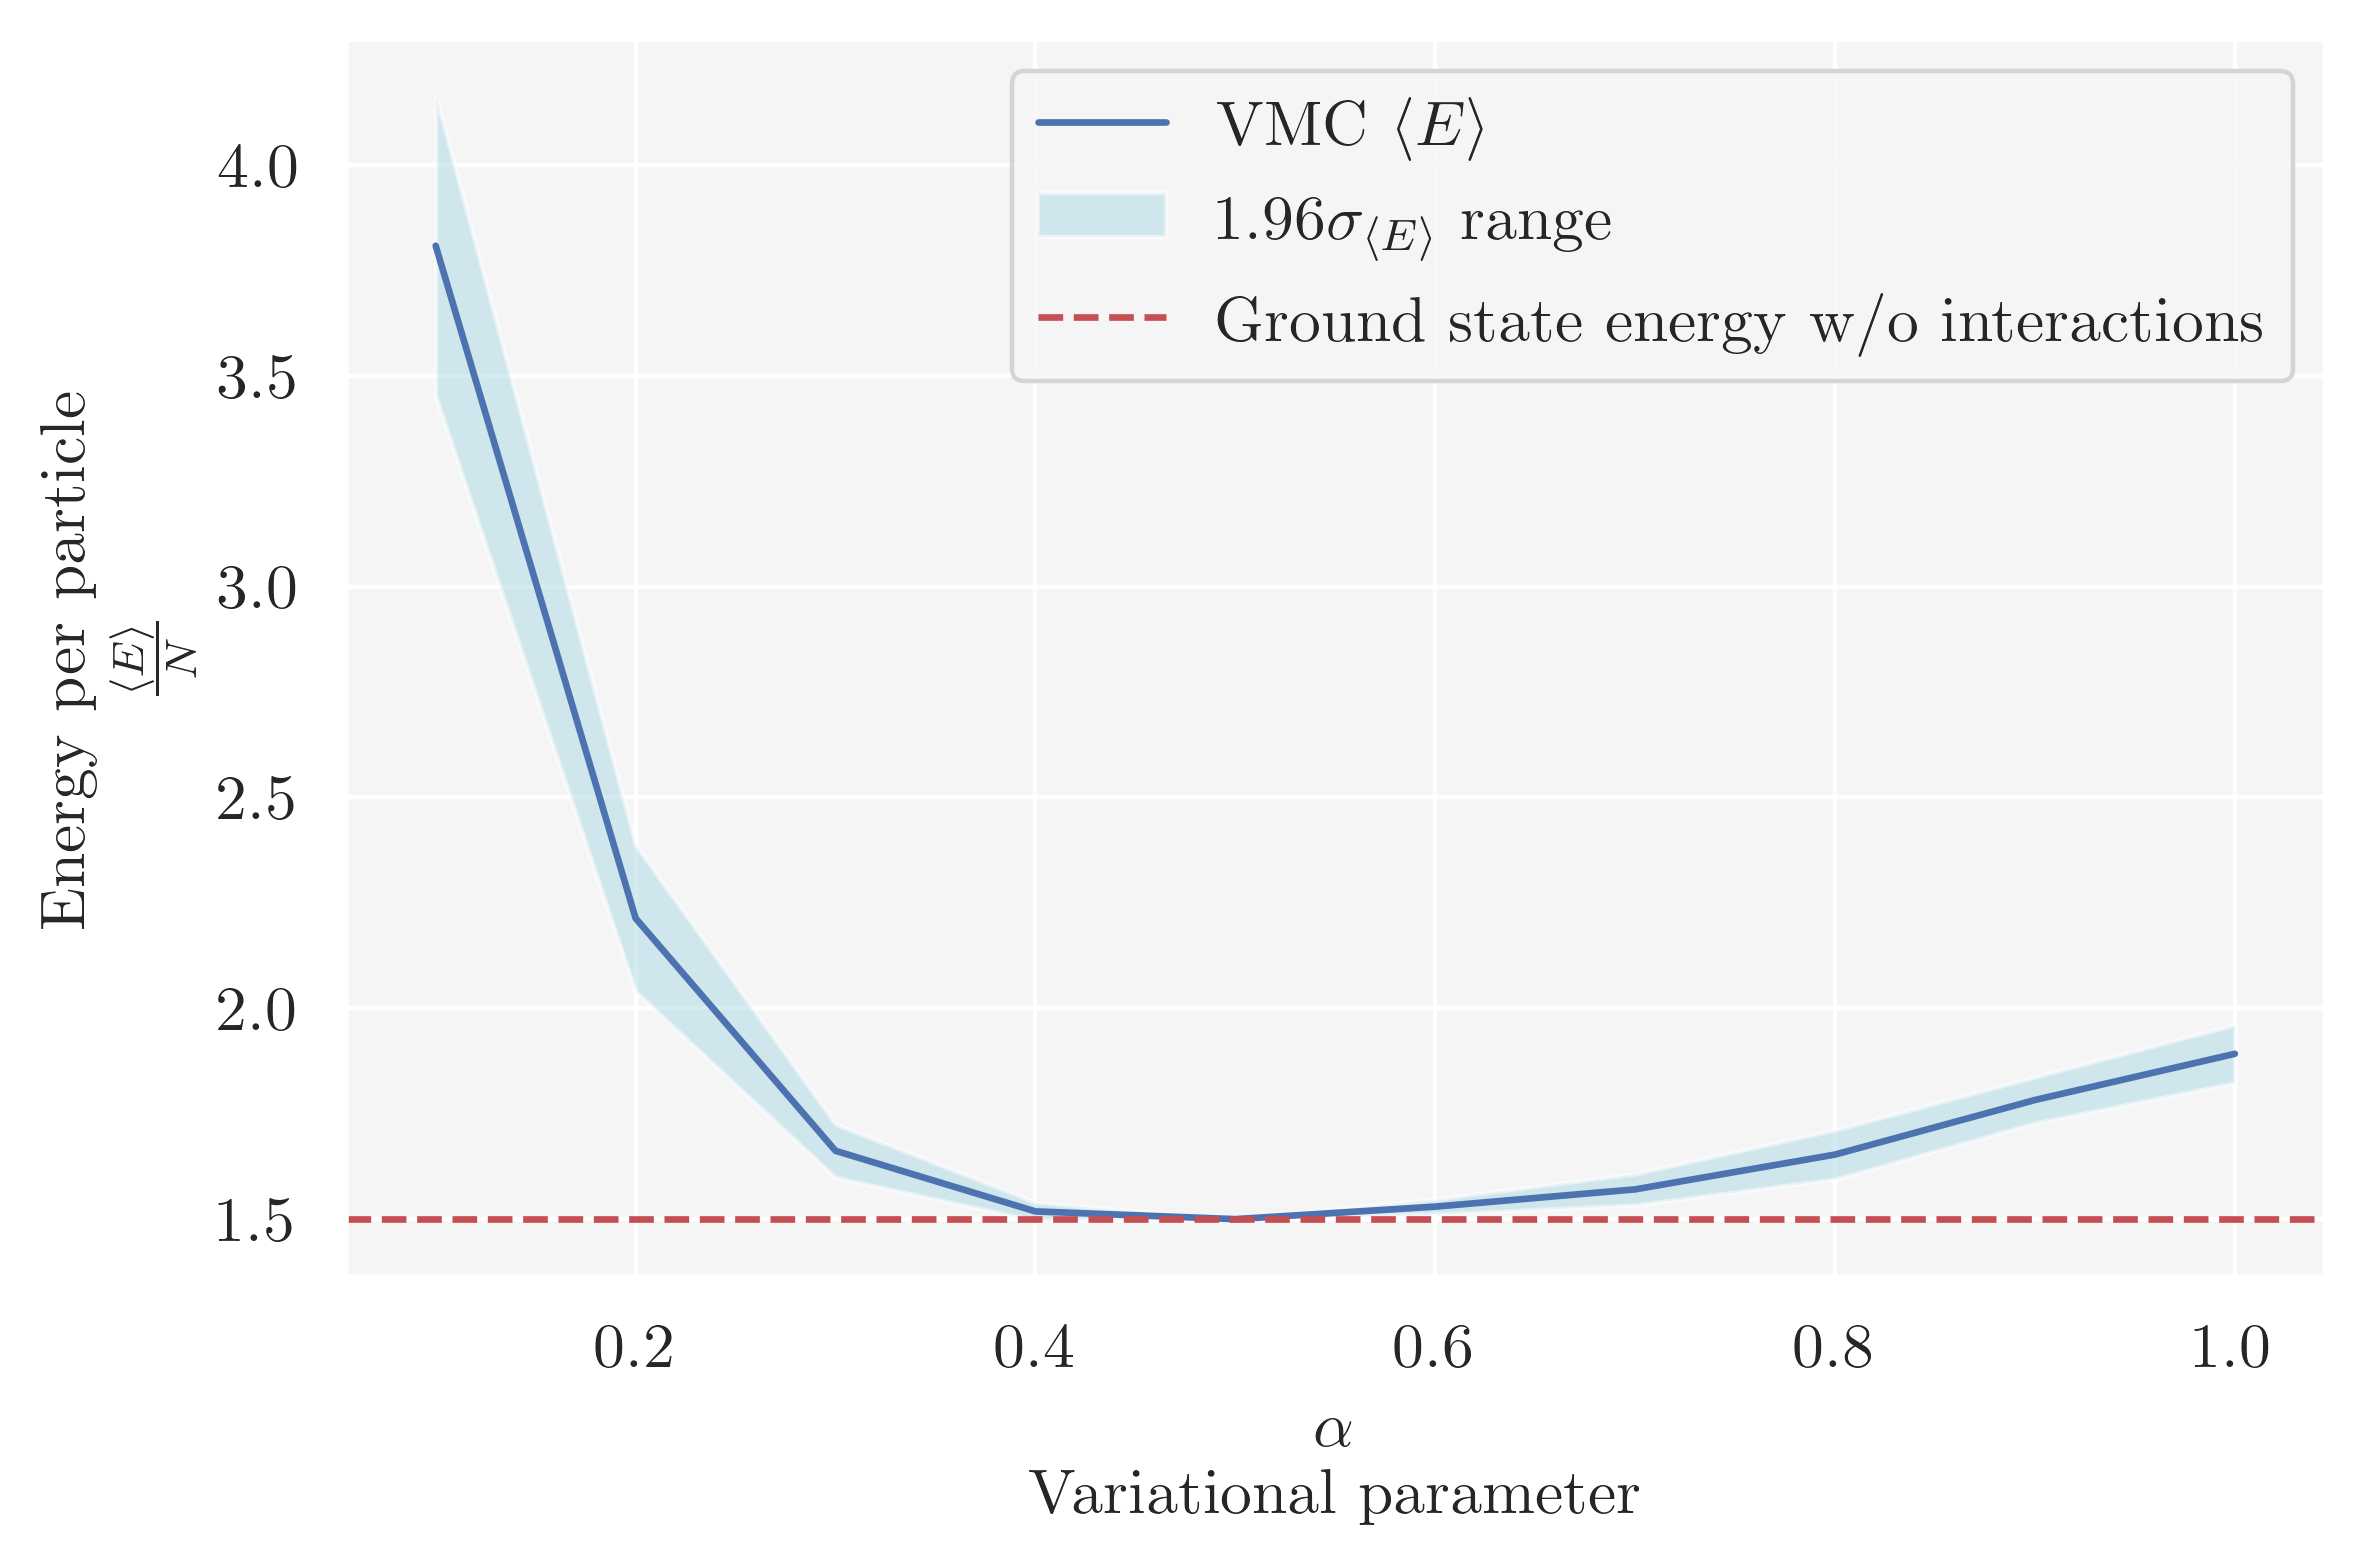

In [22]:
lower_bound = df_means_NI_N50["energy"] - 1.96*df_means_NI_N50["standard_error"]
upper_bound = df_means_NI_N50["energy"] + 1.96*df_means_NI_N50["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_NI_N50, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_NI_N50["alpha"], lower_bound, upper_bound, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_wo_interactions_N_50.pdf"), bbox_inches='tight')

## Grid search $\alpha$ with interactions

In [ ]:
N = 10
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_10 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_I_N10 = []
distance_dict = {"alpha": alphas, "distances": []}

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=2, #bytt til 8
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=5000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-7,
                            optimize=False
                           )
    #distance_dict["distances"].append(sampler.distance_samples[0])
    results_I_N10.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

In [ ]:
N=10
df_N10 = pd.concat(results_I_N10, ignore_index=True)
df_means_N10 = get_mean_w_standard_error_grid_search(df_N10, alphas)
df_means_N10["energy"] = df_means_N10["energy"]/N
df_means_N10["standard_error"] = df_means_N10["standard_error"]/N
df_means_N10["standard_error_of_the_mean"] = df_means_N10["standard_error_of_the_mean"]/N
df_means_N10

In [ ]:
lower_bound_N10 = df_means_N10["energy"] - 1.96*df_means_N10["standard_error"]
upper_bound_N10 = df_means_N10["energy"] + 1.96*df_means_N10["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_N10, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_N10["alpha"], lower_bound_N10, upper_bound_N10, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_10.pdf"), bbox_inches='tight')

In [ ]:
N = 50
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_50 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**16)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N50 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=2, #bytt til 8
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=10000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N50.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

In [ ]:
N=50
df_N50 = pd.concat(results_N50, ignore_index=True)
df_means_N50 = get_mean_w_standard_error_grid_search(df_N50, alphas)
df_means_N50["energy"] = df_means_N50["energy"]/N
df_means_N50["standard_error"] = df_means_N50["standard_error"]/N
df_means_N50["standard_error"] = df_means_N50["standard_error"].map('{:.0e}'.format)
df_means_N50["standard_error_of_the_mean"] = df_means_N50["standard_error_of_the_mean"]/N
df_means_N50

In [ ]:
lower_bound_N50 = df_means_N50["energy"] - 1.96*df_means_N50["standard_error"]
upper_bound_N50 = df_means_N50["energy"] + 1.96*df_means_N50["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_N50, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_N50["alpha"], lower_bound_N50, upper_bound_N50, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_50.pdf"), bbox_inches='tight')

In [ ]:
N = 100
dim = 3
omega = 1.

# Exact energy without interactions
NI_exact_energy_100 = exact_energy(N, dim, omega)
# Instantiate wave function
wf = vmc.ASHOIB(N, dim, omega)

# Instantiate sampler
sampler = vmc.samplers.Metropolis(wf)

# Config
nsamples = int(2**17)
alpha_step = 0.1
alphas = np.arange(0.1, 1 + alpha_step, alpha_step)

results_N100 = []

start = time.time()
for i, alpha in enumerate(alphas):
    initial_positions, scale = interact_initial_positions(wf,
                                                          alpha,
                                                          N,
                                                          dim)
    result = sampler.sample(nsamples,
                            initial_positions,
                            alpha,
                            nchains=2, #bytt til 8
                            scale=1.0,
                            seed=None,
                            warm=True,
                            warmup_iter=15000,
                            tune=True,
                            tune_iter=30000,
                            tune_interval=1000,
                            tol_tune=1e-5,
                            optimize=False
                           )
    results_N100.append(result)

end = time.time()
print("Sampler elapsed time:", end - start)

In [ ]:
N=100
df_N100 = pd.concat(results_N100, ignore_index=True)
df_means_N100 = get_mean_w_standard_error_grid_search(df_N100, alphas)
df_means_N100["energy"] = df_means_N100["energy"]/N
df_means_N100["standard_error"] = df_means_N100["standard_error"]/N
df_means_N100["standard_error"] = df_means_N100["standard_error"].map('{:.0e}'.format)
df_means_N100["standard_error_of_the_mean"] = df_means_N100["standard_error_of_the_mean"]/N
df_means_N100

In [ ]:
lower_bound_N100 = df_means_N100["energy"] - 1.96*df_means_N100["standard_error"]
upper_bound_N100 = df_means_N100["energy"] + 1.96*df_means_N100["standard_error"]
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True, dpi=200)
sns.lineplot(data=df_means_N100, x="alpha", y="energy", ax=ax, label=r'VMC $\langle E\rangle$')
ax.fill_between(df_means_N100["alpha"], lower_bound_N100, upper_bound_N100, facecolor='lightblue', alpha=0.5,
                label=r'$1.96\sigma_{\langle E\rangle}$ range')
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.set(xlabel=tex_xlabel, ylabel=tex_ylabel)
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_N_100.pdf"), bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(6,4), tight_layout=True, dpi=200)
no_int_label = '\n'.join((r'VMC $\langle E\rangle$ N=50',
                         'No interactions'))
label_sigma_no_int = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '50 non-interacting particles'))
label_sigma_10 = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '10 interacting particles'))
label_sigma_50 = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '50 interacting particles'))
label_sigma_100 = '\n'.join((r'$1.96\sigma_{\langle E\rangle}$ range', 
                               '100 interacting particles'))
sns.lineplot(data=df_means_NI_N50, x="alpha", y="energy", ax=ax, color="blue", label=r'VMC $\langle E\rangle$ N=50, no interactions')
#ax.fill_between(df_means_NI_N50["alpha"], lower_bound, upper_bound, facecolor='lightblue', alpha=0.5)
               #label=label_sigma_no_int)
sns.lineplot(data=df_means_N10, x="alpha", y="energy", ax=ax, color="yellow", label=r'VMC $\langle E \rangle$ N=10, interactions')
#ax.fill_between(df_means_N10["alpha"], lower_bound_N10, upper_bound_N10, facecolor='gold', alpha=0.5)
                #label=label_sigma_10)
sns.lineplot(data=df_means_N50, x="alpha", y="energy", ax=ax, color="red", label=r'VMC $\langle E\rangle$ N=50, interactions')
#ax.fill_between(df_means_N50["alpha"], lower_bound_N50, upper_bound_N50, facecolor='tomato', alpha=0.5)
                #label=label_sigma_50)
sns.lineplot(data=df_means_N100, x="alpha", y="energy", ax=ax, color="purple", label=r'VMC $\langle E\rangle$ N=100, interactions')
#ax.fill_between(df_means_N100["alpha"], lower_bound_N100, upper_bound_N100, facecolor='magenta', alpha=0.5)
                #label=label_sigma_100)
ax.axhline(1.5, ls='--', color='r', label='Ground state energy w/o interactions')
tex_xlabel = '\n'.join((r'$\alpha$',
                      'Variational parameter'))
tex_ylabel = '\n'.join(('Energy per particle',
                        r'$\frac{\langle E\rangle}{N}$'))
ax.legend()
plt.show()

fig.savefig(fig_path("grid_search_analytical_w_interactions_all_N.pdf"), bbox_inches='tight')

### Making table for $\alpha=0.5$

In [ ]:
table = {"Number of particles": [50, 10, 50, 100], "Interactions": ["Off", "On", "On", "On"], "Lowest energy": [], "Error": [], "Optimal alpha": [0.5, 0.5, 0.5, 0.5]}
table["Lowest energy"].append(df_means_NI_N50["energy"][4])
table["Lowest energy"].append(df_means_N10["energy"][4])
table["Lowest energy"].append(df_means_N50["energy"][4])
table["Lowest energy"].append(df_means_N100["energy"][4])
table["Error"].append(df_means_NI_N50["standard_error"][4])
table["Error"].append(df_means_N10["standard_error"][4])
table["Error"].append(df_means_N50["standard_error"][4])
table["Error"].append(df_means_N100["standard_error"][4])
table = pd.DataFrame(data=table)
table["Lowest energy"] = table["Lowest energy"].map('{:.5f}'.format)

#df_to_latex(table, "energy_table.tex")
table